In [1]:
import xdem 
import matplotlib.pyplot as plt 
import numpy as np
import numpy.ma as ma 
import re 
import pandas as pd 
import geopandas as gpd
import scipy 
import statsmodels.api as sm 
import geoutils as gu
import rasterio as rio
import skimage
import seaborn as sns

from scipy.ndimage import gaussian_filter

In [2]:
sp = gpd.read_file("/home/gentleprotector/plus_ss24/data_for_analysis/new/sampling_points_new.geojson") 
sp.drop('id', axis=1, inplace=True)
sp = sp.dropna()
sp.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 875 entries, 0 to 998
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   ASC_1     875 non-null    float64 
 1   ASC_2     875 non-null    float64 
 2   ASC_3     875 non-null    float64 
 3   ASC_4     875 non-null    float64 
 4   ASC_5     875 non-null    float64 
 5   ASC_6     875 non-null    float64 
 6   DESC1     875 non-null    float64 
 7   DESC2     875 non-null    float64 
 8   DESC3     875 non-null    float64 
 9   DESC4     875 non-null    float64 
 10  DESC5     875 non-null    float64 
 11  DESC6     875 non-null    float64 
 12  REF1      875 non-null    float64 
 13  ASP1      875 non-null    float64 
 14  geometry  875 non-null    geometry
dtypes: float64(14), geometry(1)
memory usage: 109.4 KB


In [3]:
sp

,ASC_1,ASC_2,ASC_3,ASC_4,ASC_5,ASC_6,DESC1,DESC2,DESC3,DESC4,DESC5,DESC6,REF1,ASP1,geometry
0,2427.181152,2.714799,0.359140,2421.524902,-5.656250,2417.621094,2372.994629,0.521953,0.260535,2421.454590,48.459961,2416.786621,2417.248291,63.141342,POINT (-8.01129 31.11857)
1,2629.532471,-1.998909,0.106656,2547.007080,-82.525391,2561.653809,2569.394043,0.728053,0.854037,2541.629150,-27.764893,2555.120117,2568.365967,319.079071,POINT (-8.01464 31.13511)
2,2420.290771,2.016956,0.453821,2374.497559,-45.793213,2377.276367,2289.192627,1.874222,0.409803,2374.771973,85.579346,2379.621582,2379.621582,358.911438,POINT (-8.00709 31.11804)
3,2259.045410,-1.992884,0.199998,2214.247803,-44.797607,2210.501709,2108.137695,1.882013,0.588500,2212.576660,104.438965,2209.582764,2217.607666,294.754333,POINT (-8.02918 31.11616)
4,2446.870117,-2.091777,0.611946,2416.020508,-30.849609,2407.700928,2312.570068,0.747296,0.712066,2416.068604,103.498535,2406.608154,2406.608154,213.795990,POINT (-8.01445 31.12252)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,2620.458984,-2.714425,0.630671,2586.745117,-33.713867,2585.813232,2601.445801,-1.632881,0.590516,2584.849854,-16.595947,2582.877686,2587.787109,267.264099,POINT (-8.01151 31.13106)
993,2414.540283,2.535711,0.465999,2378.214844,-36.325439,2376.060303,2279.526367,-0.629773,0.344893,2376.836426,97.310059,2374.555176,2380.476318,280.705109,POINT (-8.02628 31.11649)
994,2223.932373,1.909160,0.705051,2167.622559,-56.309814,2176.602051,2166.805664,-1.170922,0.322029,2161.936523,-4.869141,2169.093506,2181.686279,327.338470,POINT (-8.03115 31.11545)
996,2461.486084,-1.328471,0.757653,2435.480469,-26.005615,2423.173096,2348.715820,-1.899700,0.584253,2439.769287,91.053467,2431.572998,2418.822021,147.023239,POINT (-8.00853 31.12073)


In [4]:
sp['ER_ASC'] = sp['ASC_1'] - sp['REF1']
sp['ER_DESC'] = sp['DESC1'] - sp['REF1']

In [5]:
# Calculate ASPECT groups 
aspect_conditions = [
    (sp['ASP1'] <= 90),
    (sp['ASP1'] > 90) & (sp['ASP1'] <= 180), 
    (sp['ASP1'] > 180) & (sp['ASP1'] <= 270), 
    (sp['ASP1'] > 270)
]

aspect_values = ['N_NE', 'E_SE', 'S_SW', 'W_NW']

sp['aspect'] = np.select(aspect_conditions, aspect_values) 

In [6]:
sp

,ASC_1,ASC_2,ASC_3,ASC_4,ASC_5,ASC_6,DESC1,DESC2,DESC3,DESC4,DESC5,DESC6,REF1,ASP1,geometry,ER_ASC,ER_DESC,aspect
0,2427.181152,2.714799,0.359140,2421.524902,-5.656250,2417.621094,2372.994629,0.521953,0.260535,2421.454590,48.459961,2416.786621,2417.248291,63.141342,POINT (-8.01129 31.11857),9.932861,-44.253662,N_NE
1,2629.532471,-1.998909,0.106656,2547.007080,-82.525391,2561.653809,2569.394043,0.728053,0.854037,2541.629150,-27.764893,2555.120117,2568.365967,319.079071,POINT (-8.01464 31.13511),61.166504,1.028076,W_NW
2,2420.290771,2.016956,0.453821,2374.497559,-45.793213,2377.276367,2289.192627,1.874222,0.409803,2374.771973,85.579346,2379.621582,2379.621582,358.911438,POINT (-8.00709 31.11804),40.669189,-90.428955,W_NW
3,2259.045410,-1.992884,0.199998,2214.247803,-44.797607,2210.501709,2108.137695,1.882013,0.588500,2212.576660,104.438965,2209.582764,2217.607666,294.754333,POINT (-8.02918 31.11616),41.437744,-109.469971,W_NW
4,2446.870117,-2.091777,0.611946,2416.020508,-30.849609,2407.700928,2312.570068,0.747296,0.712066,2416.068604,103.498535,2406.608154,2406.608154,213.795990,POINT (-8.01445 31.12252),40.261963,-94.038086,S_SW
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
992,2620.458984,-2.714425,0.630671,2586.745117,-33.713867,2585.813232,2601.445801,-1.632881,0.590516,2584.849854,-16.595947,2582.877686,2587.787109,267.264099,POINT (-8.01151 31.13106),32.671875,13.658691,S_SW
993,2414.540283,2.535711,0.465999,2378.214844,-36.325439,2376.060303,2279.526367,-0.629773,0.344893,2376.836426,97.310059,2374.555176,2380.476318,280.705109,POINT (-8.02628 31.11649),34.063965,-100.949951,W_NW
994,2223.932373,1.909160,0.705051,2167.622559,-56.309814,2176.602051,2166.805664,-1.170922,0.322029,2161.936523,-4.869141,2169.093506,2181.686279,327.338470,POINT (-8.03115 31.11545),42.246094,-14.880615,W_NW
996,2461.486084,-1.328471,0.757653,2435.480469,-26.005615,2423.173096,2348.715820,-1.899700,0.584253,2439.769287,91.053467,2431.572998,2418.822021,147.023239,POINT (-8.00853 31.12073),42.664062,-70.106201,E_SE


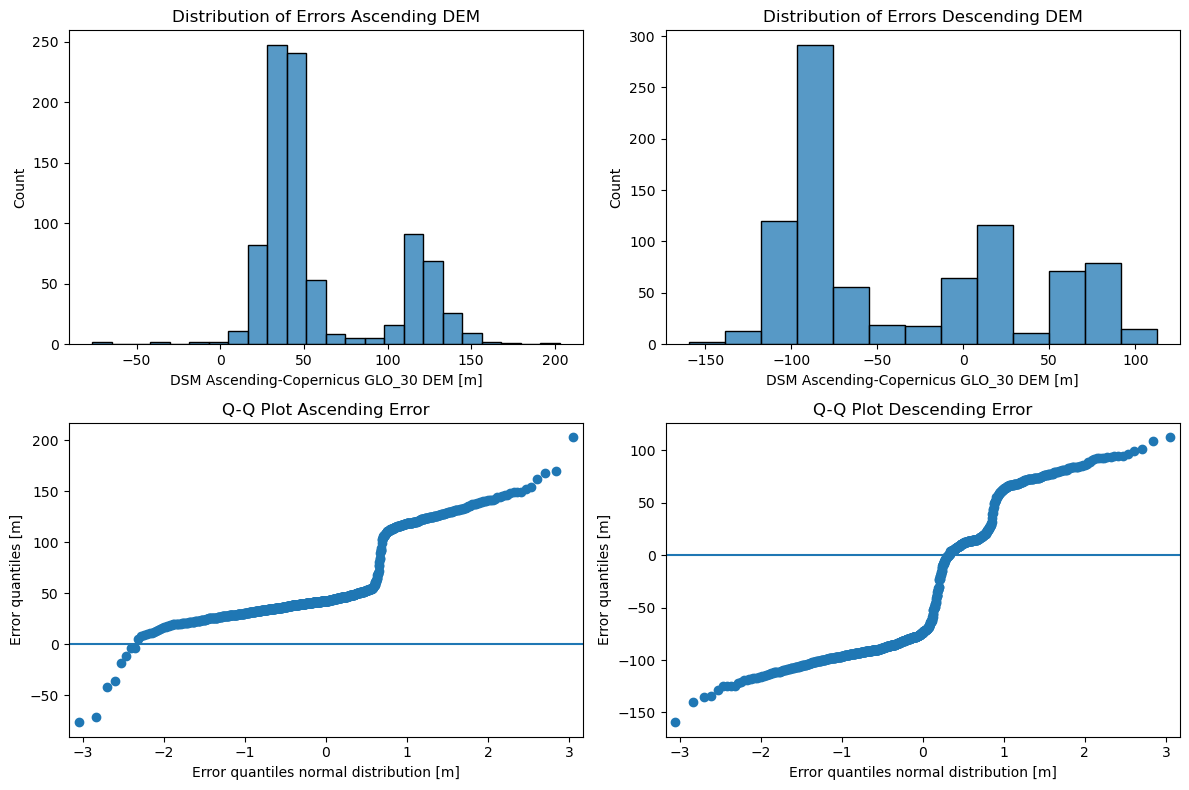

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8)) 

sns.histplot(sp['ER_ASC'], ax=axs[0, 0]) 
axs[0, 0].set_title('Distribution of Errors Ascending DEM') 
axs[0, 0].set_xlabel('DSM Ascending-Copernicus GLO_30 DEM [m]')
sns.histplot(sp['ER_DESC'], ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Errors Descending DEM') 
axs[0, 1].set_xlabel('DSM Ascending-Copernicus GLO_30 DEM [m]') 

sm.qqplot(sp['ER_ASC'], ax=axs[1, 0])
axs[1, 0].axhline(y=0)
axs[1, 0].set_title('Q-Q Plot Ascending Error') 
axs[1, 0].set_ylabel('Error quantiles [m]')
axs[1, 0].set_xlabel('Error quantiles normal distribution [m]')
sm.qqplot(sp['ER_DESC'], ax=axs[1, 1])
axs[1, 1].set_title('Q-Q Plot Descending Error') 
axs[1, 1].set_ylabel('Error quantiles [m]')
axs[1, 1].set_xlabel('Error quantiles normal distribution [m]')

axs[1, 1].axhline(y=0)

plt.tight_layout() 
fig.savefig('er_hist_qq.png' ,dpi=300)
plt.show() 

In [8]:
grouped_sp = sp.groupby('aspect') 
grouped_sp.size()

aspect
E_SE    231
N_NE    107
S_SW    279
W_NW    258
dtype: int64

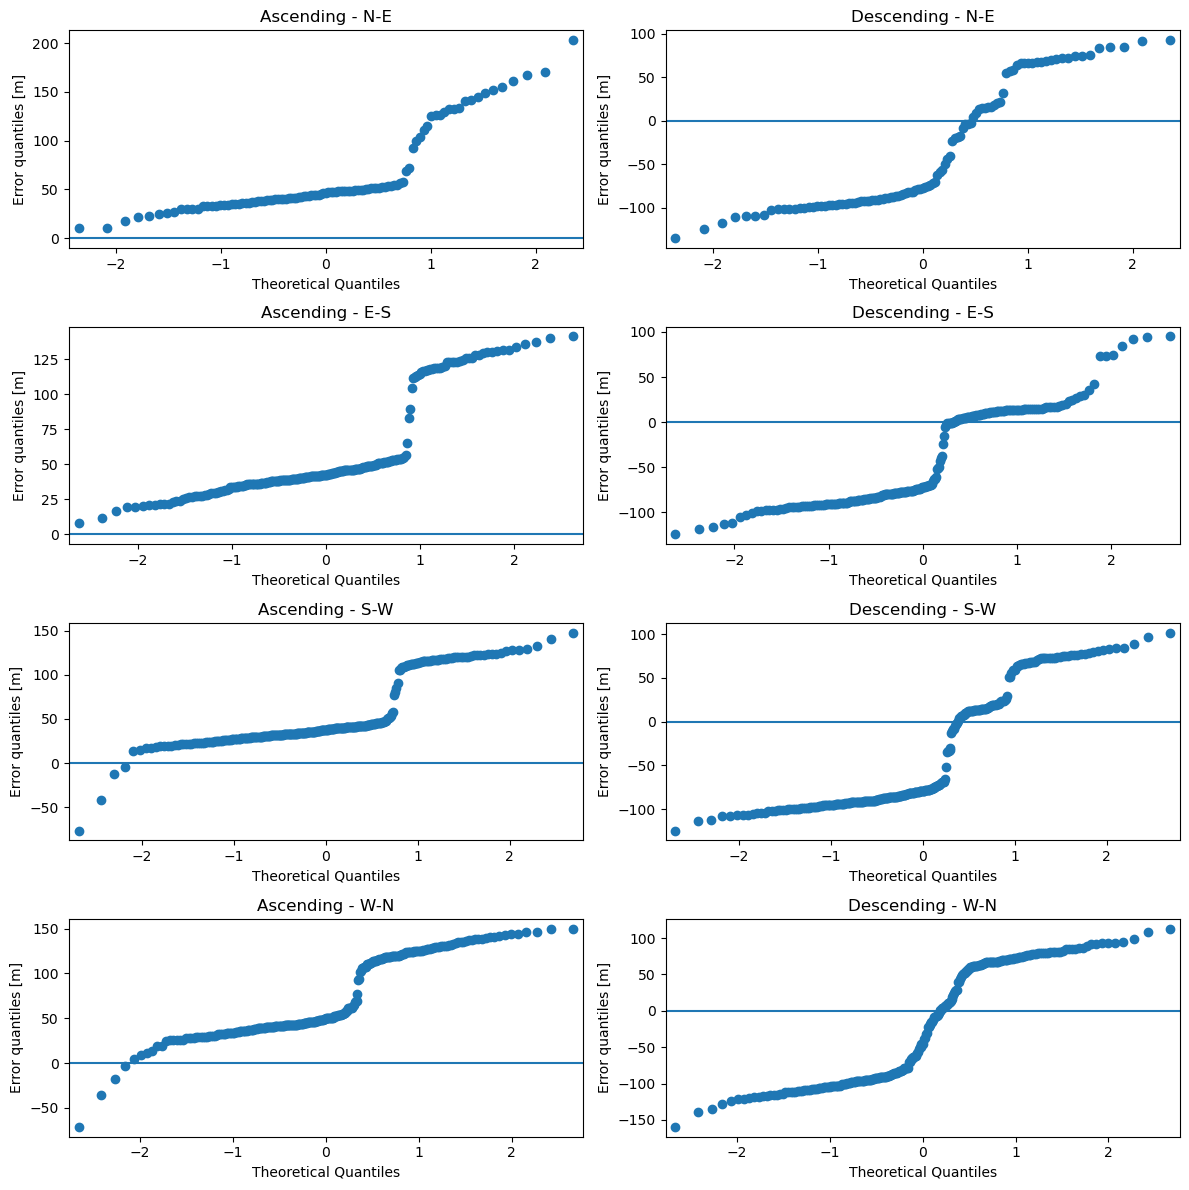

In [9]:
fig, axs = plt.subplots(4, 2, figsize=(12, 12)) 


group = grouped_sp.get_group('N_NE')
sm.qqplot(group['ER_ASC'], ax=axs[0, 0])
axs[0, 0].axhline(y=0)
axs[0, 0].set_title('Ascending - N-E') 
axs[0, 0].set_ylabel('Error quantiles [m]')
sm.qqplot(group['ER_DESC'], ax=axs[0, 1])
axs[0, 1].set_title('Descending - N-E') 
axs[0, 1].axhline(y=0)
axs[0, 1].set_ylabel('Error quantiles [m]')

group = grouped_sp.get_group('E_SE')
sm.qqplot(group['ER_ASC'], ax=axs[1, 0])
axs[1, 0].axhline(y=0)
axs[1, 0].set_title('Ascending - E-S')
axs[1, 0].set_ylabel('Error quantiles [m]')
sm.qqplot(group['ER_DESC'], ax=axs[1, 1])
axs[1, 1].set_title('Descending - E-S') 
axs[1, 1].axhline(y=0)
axs[1, 1].set_ylabel('Error quantiles [m]')

group = grouped_sp.get_group('S_SW')
sm.qqplot(group['ER_ASC'], ax=axs[2, 0])
axs[2, 0].axhline(y=0)
axs[2, 0].set_title('Ascending - S-W') 
sm.qqplot(group['ER_DESC'], ax=axs[2, 1])
axs[2, 1].set_title('Descending - S-W') 
axs[2, 1].axhline(y=0)
axs[2, 0].set_ylabel('Error quantiles [m]')
axs[2, 1].set_ylabel('Error quantiles [m]')

group = grouped_sp.get_group('W_NW')
sm.qqplot(group['ER_ASC'], ax=axs[3, 0])
axs[3, 0].axhline(y=0)
axs[3, 0].set_title('Ascending - W-N') 
sm.qqplot(group['ER_DESC'], ax=axs[3, 1])
axs[3, 1].set_title('Descending - W-N') 
axs[3, 1].axhline(y=0)
axs[3, 0].set_ylabel('Error quantiles [m]')
axs[3, 1].set_ylabel('Error quantiles [m]')

plt.tight_layout() 
fig.savefig('er_qq_aspect.png' ,dpi=300)
plt.show() 

In [10]:
def calculate_statistics(data, columns): 
    # ascending
    series = data[columns[0]]
    mean_asc = series.mean() 
    median_asc = series.median()
    sddev_asc = series.std()
    nmad_asc = 1.4826*np.median(abs(series - median_asc))
    q_68_asc = abs(series).quantile(0.683)
    q_95_asc = abs(series).quantile(0.95)
    min_asc = series.min()
    max_asc = series.max()
    mean_asc_coh = data[columns[2]].mean() 

    # descending
    series = data[columns[1]]
    mean_desc = series.mean()
    sddev_desc = series.std()
    median_desc =series.median()
    nmad_desc = 1.4826*np.median(abs(series- median_asc))
    q_68_desc = abs(series).quantile(0.683)
    q_95_desc = abs(series).quantile(0.95)
    min_desc = series.min()
    max_desc = series.max
    mean_desc_coh = data[columns[3]].mean() 


    statistics_dict = {
    'Statistic': ['Mean', 'Standard Deviation', 'Median', 'NMAD', '68th Percentile', '95th Percentile', 'Min', 'Max', 'Mean Coherence'],
    'ASC': [mean_asc, sddev_asc, median_asc, nmad_asc, q_68_asc, q_95_asc, min_asc, max_asc, mean_asc_coh],
    'DESC': [mean_desc, sddev_desc, median_desc, nmad_desc, q_68_desc, q_95_desc, min_desc, max_desc, mean_desc_coh]
    }

    df_acc_statistics = pd.DataFrame(statistics_dict)
    return df_acc_statistics

In [11]:
asp_quadrants = ['N_NE', 'E_SE', 'S_SW', 'W_NW']

df_statistics = [] 

df_statistics.append(calculate_statistics(data=sp, columns=('ER_ASC', 'ER_DESC', 'ASC_3', 'DESC3')))  

for i in asp_quadrants: 
    data = grouped_sp.get_group(i)
    columns = ('ER_ASC', 'ER_DESC') 
    df = calculate_statistics(data=data, columns=('ER_ASC', 'ER_DESC', 'ASC_3', 'DESC3')) 
    df_statistics.append(df)



In [12]:
keys = ['all'] + asp_quadrants
statistics_dict = {key: value for key, value in zip(keys, df_statistics)}

In [13]:
statistics_dict

{'all':             Statistic         ASC  \
 0                Mean   59.453410   
 1  Standard Deviation   39.397293   
 2              Median   42.626465   
 3                NMAD   15.282797   
 4     68th Percentile   52.143829   
 5     95th Percentile  131.678784   
 6                 Min  -76.585938   
 7                 Max  202.867676   
 8      Mean Coherence    0.576495   
 
                                                 DESC  
 0                                         -34.958553  
 1                                          67.372967  
 2                                         -73.519043  
 3                                          172.19733  
 4                                          89.513142  
 5                                         108.693872  
 6                                        -159.532837  
 7  <bound method Series.max of 0      -44.253662\...  
 8                                           0.575045  ,
 'N_NE':             Statistic         ASC  \
 0  

# Analysis using xdem package 

In [2]:
#asc = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/asc_ne.tif", bands=1) 
asc = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/new/asc_clip_new.tif", bands=1) 
asc.load()
#desc = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/desc_ne.tif", bands=1) 
desc = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/new/desc_clip_new.tif", bands=1) 
desc.load() 
#ref = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/ref_asc_ne.tif")    
ref = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/new/ref_clip_new.tif")
ref.load()

asc_bands = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/new/asc_clip_new.tif")
asc_bands.load(bands=2)
asc_bands = asc_bands.reproject(crs=26191)
desc_bands = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/new/desc_clip_new.tif")
desc_bands.load(bands=2)
desc_bands = desc_bands.reproject(crs=26191)

asc_coherence = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/new/asc_clip_new.tif")
asc_coherence.load(bands=3)
asc_coherence = asc_coherence.reproject(crs=26191)

desc_coherence = gu.Raster("/home/gentleprotector/plus_ss24/data_for_analysis/new/desc_clip_new.tif")
desc_coherence.load(bands=3)
desc_coherence = asc_coherence.reproject(crs=26191)


/home/gentleprotector/miniconda3/envs/xdem_analysis/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(
/home/gentleprotector/miniconda3/envs/xdem_analysis/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(
/home/gentleprotector/miniconda3/envs/xdem_analysis/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.warn(
/home/gentleprotector/miniconda3/envs/xdem_analysis/lib/python3.11/site-packages/geoutils/raster/raster.py:1891: UserWarning: Setting default nodata -99999 to mask non-finite values found in the array, as no nodata value was defined.
  warnings.wa

In [3]:
asc[asc==0] = np.nan
desc[desc==0] = np.nan 
ref[ref==0] = np.nan 

In [4]:
asc.set_mask(asc.data == 0)
desc.set_mask(desc.data == 0) 
ref.set_mask(ref.data == 0) 

asc_bands.set_mask(asc_bands.data==0)
desc_bands.set_mask(desc_bands.data==0)

In [5]:
dem_asc = xdem.DEM(asc)
dem_desc = xdem.DEM(desc)
dem_ref = xdem.DEM(ref)
dem_asc.nodata = np.nan
dem_desc.nodata = np.nan
dem_ref.nodata = np.nan

In [6]:
dem_ref = dem_ref.reproject(crs=26191)
dem_asc = dem_asc.reproject(crs=26191) 
dem_desc = dem_desc.reproject(crs=26191) 

In [7]:
dem_ref.set_vcrs('Ellipsoid') 
dem_asc.set_vcrs('Ellipsoid') 
dem_desc.set_vcrs('Ellipsoid') 

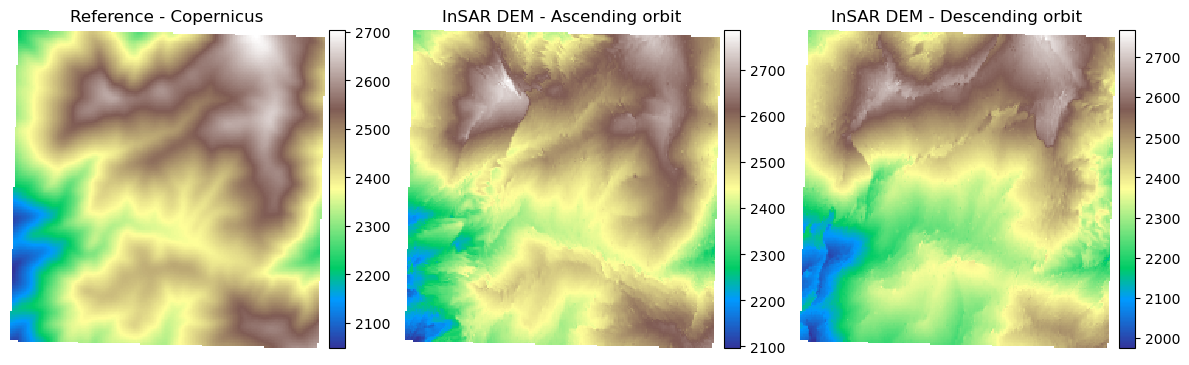

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(12,8)) 

dem_ref.plot(cmap="terrain", ax=axs[0])
axs[0].set_title('Reference - Copernicus') 
dem_asc.plot(cmap='terrain', ax=axs[1])
axs[1].set_title('InSAR DEM - Ascending orbit')
dem_desc.plot(cmap='terrain', ax=axs[2])
axs[2].set_title('InSAR DEM - Descending orbit')

for ax in axs: 
    ax.axis('off')

plt.tight_layout() 
#fig.savefig('DEM_all.png', dpi=300) 
plt.show() 

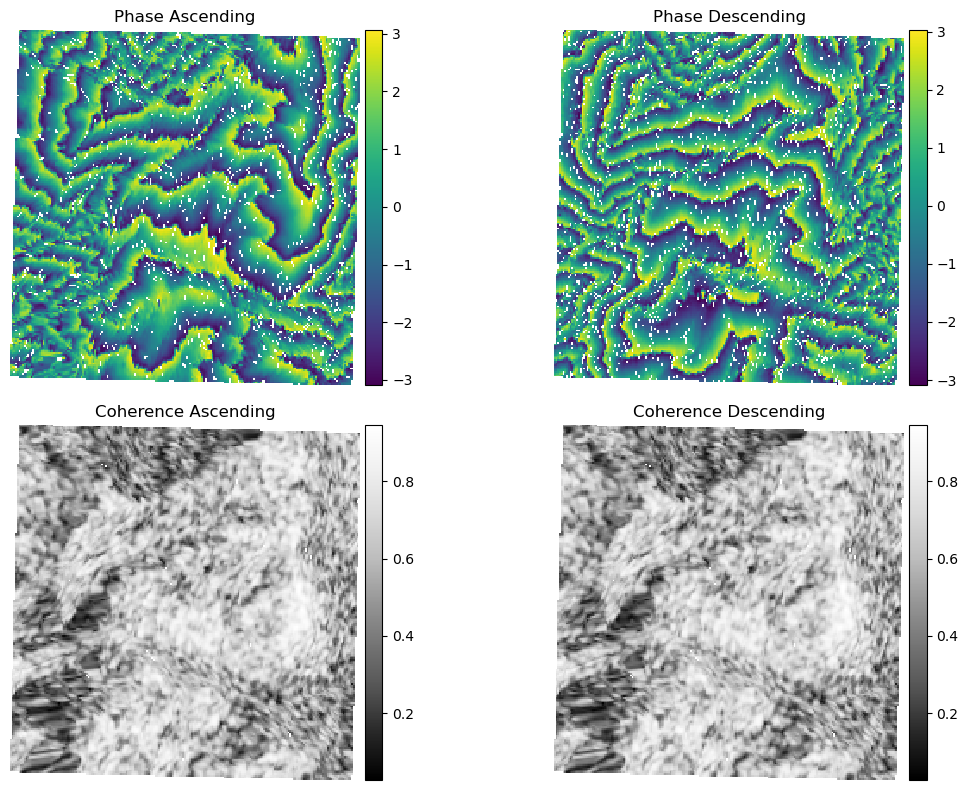

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(12,8)) 

asc_bands.plot(ax=axs[0, 0])
desc_bands.plot(ax=axs[0, 1])
axs[0, 0].set_title('Phase Ascending')
axs[0, 1].set_title('Phase Descending') 

asc_coherence.plot(ax=axs[1, 0], cmap='Greys_r')
desc_coherence.plot(ax=axs[1, 1], cmap='Greys_r')
axs[1, 0].set_title('Coherence Ascending')
axs[1, 1].set_title('Coherence Descending') 

for ax in axs: 
    for i in ax:
        i.axis('off')

plt.tight_layout() 
#fig.savefig('coherence.png', dpi=300) 
plt.show() 

In [10]:
dem_asc = dem_asc.reproject(dem_ref)
dem_desc = dem_desc.reproject(dem_ref)

In [11]:
ddem_asc = dem_asc - dem_ref
ddem_desc = dem_desc - dem_ref  

med_asc, nmad_asc = np.median(ddem_asc), xdem.spatialstats.nmad(ddem_asc)
print(f"Error ascending: median = {med_asc:.2f} - NMAD = {nmad_asc:.2f} m")
med_desc, nmad_desc = np.median(ddem_desc), xdem.spatialstats.nmad(ddem_desc)
print(f"Error desencing: median = {med_desc:.2f} - NMAD = {nmad_desc:.2f} m")

Error ascending: median = 42.97 - NMAD = 13.99 m
Error desencing: median = -77.50 - NMAD = 35.81 m


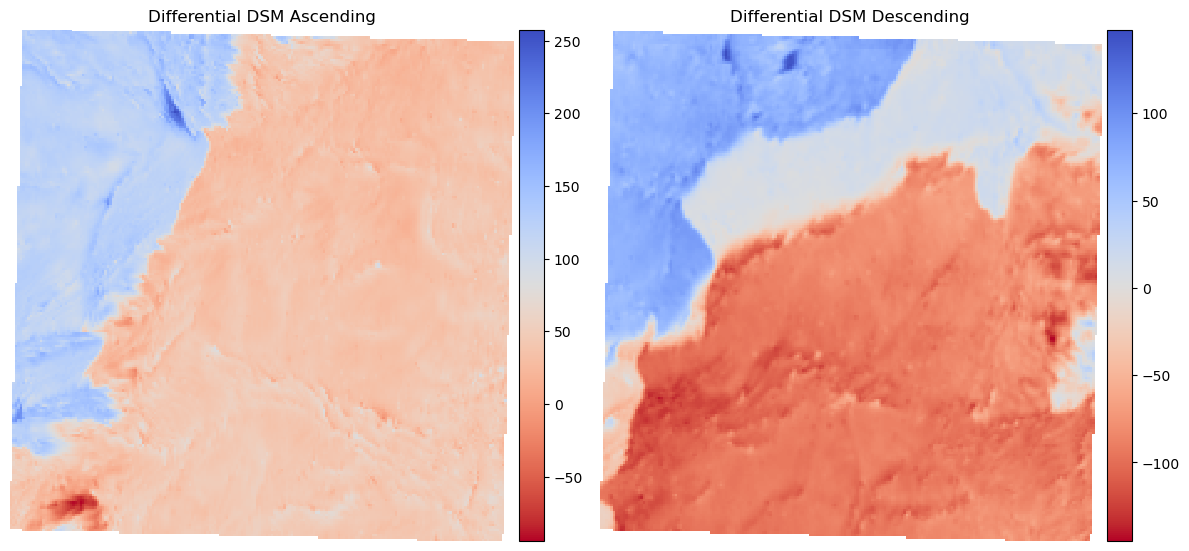

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12,8)) 

ddem_asc.plot(cmap="coolwarm_r", ax=axs[0])
axs[0].set_title('Differential DSM Ascending') 
ddem_desc.plot(cmap='coolwarm_r', ax=axs[1])
axs[1].set_title('Differential DSM Descending')


for ax in axs: 
    ax.axis('off')

plt.tight_layout() 
#fig.savefig('diff_dem.png', dpi=300) 
plt.show() 

In [13]:
plt_extent = [
    dem_ref.bounds.left,
    dem_ref.bounds.right,
    dem_ref.bounds.bottom,
    dem_ref.bounds.top,
]

blockwise = xdem.coreg.BlockwiseCoreg(xdem.coreg.NuthKaab(), subdivision=20)

blockwise.fit(dem_ref, dem_asc)
coreg_asc = blockwise.apply(dem_asc)


blockwise = xdem.coreg.BlockwiseCoreg(xdem.coreg.NuthKaab(), subdivision=20)
blockwise.fit(dem_ref, dem_desc) 
coreg_desc = blockwise.apply(dem_desc)

In [14]:
ddem_asc_coreg = coreg_asc - dem_ref 
ddem_desc_coreg = coreg_desc - dem_ref 

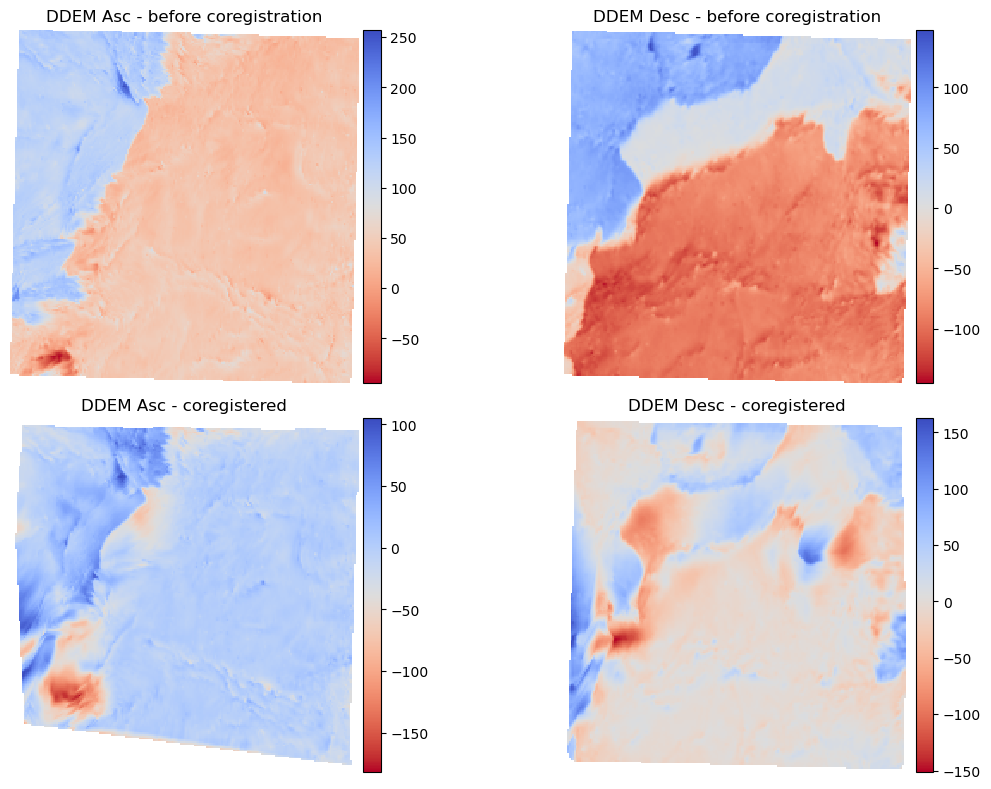

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12,8)) 

# plots 
ddem_asc.plot(cmap="coolwarm_r", ax=axs[0, 0])
ddem_desc.plot(cmap='coolwarm_r', ax=axs[0, 1])
ddem_asc_coreg.plot(cmap='coolwarm_r', ax=axs[1, 0])
ddem_desc_coreg.plot(cmap='coolwarm_r', ax=axs[1, 1])


axs[0, 0].set_title('DDEM Asc - before coregistration') 
axs[0, 1].set_title('DDEM Desc - before coregistration')
axs[1, 0].set_title('DDEM Asc - coregistered') 
axs[1, 1].set_title('DDEM Desc - coregistered')

for ax in axs: 
    for i in ax:
        i.axis('off')

plt.tight_layout() 
#fig.savefig("DSM correction.png", dpi=300) 
plt.show() 

In [16]:
print(f"Ascending - STD; NMAD: {np.nanstd(ddem_asc_coreg.data):.2f}m; {xdem.spatialstats.nmad(ddem_asc_coreg.data):.2f}m.")
print(f"Descending - STD; NMAD: {np.nanstd(ddem_desc_coreg.data):.2f}m; {xdem.spatialstats.nmad(ddem_desc_coreg.data):.2f}m.")

Ascending - STD; NMAD: 25.21m; 9.25m.
Descending - STD; NMAD: 31.23m; 14.95m.


In [17]:
ddem_asc_coreg.set_mask(np.abs(ddem_asc_coreg.data) > 4 * xdem.spatialstats.nmad(ddem_asc_coreg.data))
ddem_desc_coreg.set_mask(np.abs(ddem_desc_coreg.data) > 4 * xdem.spatialstats.nmad(ddem_desc_coreg.data))

In [18]:
print(f"Ascending - STD; NMAD: {np.nanstd(ddem_asc_coreg.data):.2f}m; {xdem.spatialstats.nmad(ddem_asc_coreg.data):.2f}m.")
print(f"Descending - STD; NMAD: {np.nanstd(ddem_desc_coreg.data):.2f}m; {xdem.spatialstats.nmad(ddem_desc_coreg.data):.2f}m.")

Ascending - STD; NMAD: 12.13m; 7.67m.
Descending - STD; NMAD: 21.21m; 12.69m.


In [19]:
med, nmad = np.median(ddem_asc_coreg), xdem.spatialstats.nmad(ddem_asc_coreg)
print(f"Error ascending: median = {med:.2f} - NMAD = {nmad:.2f} m")

med, nmad = np.median(ddem_desc_coreg), xdem.spatialstats.nmad(ddem_desc_coreg)
print(f"Error desencing: median = {med:.2f} - NMAD = {nmad:.2f} m")

Error ascending: median = -1.13 - NMAD = 7.67 m
Error desencing: median = -0.49 - NMAD = 12.69 m


In [20]:
slope, aspect, planc, profc, maxc = xdem.terrain.get_terrain_attribute(
    dem=dem_ref, attribute=["slope", "aspect", "planform_curvature", "profile_curvature", "maximum_curvature"]
)

ddem_arr_asc = ddem_asc_coreg.data
ddem_arr_desc = ddem_desc_coreg.data
slope_arr = slope.data
aspect_arr = aspect.data
planc_arr = planc.data 
profc_arr = profc.data
maximum_curvature_arr = maxc.data

In [21]:
df_asc = xdem.spatialstats.nd_binning(
    values=ddem_arr_asc,
    list_var=[slope_arr, aspect_arr, maximum_curvature_arr],
    list_var_names=["slope", "aspect", "maxc"],
    statistics=["count", xdem.spatialstats.nmad],
    list_var_bins=30,
)

df_desc = xdem.spatialstats.nd_binning(
    values=ddem_arr_desc,
    list_var=[slope_arr, aspect_arr, maximum_curvature_arr],
    list_var_names=["slope", "aspect", "maxc"],
    statistics=["count", xdem.spatialstats.nmad],
    list_var_bins=30,
)

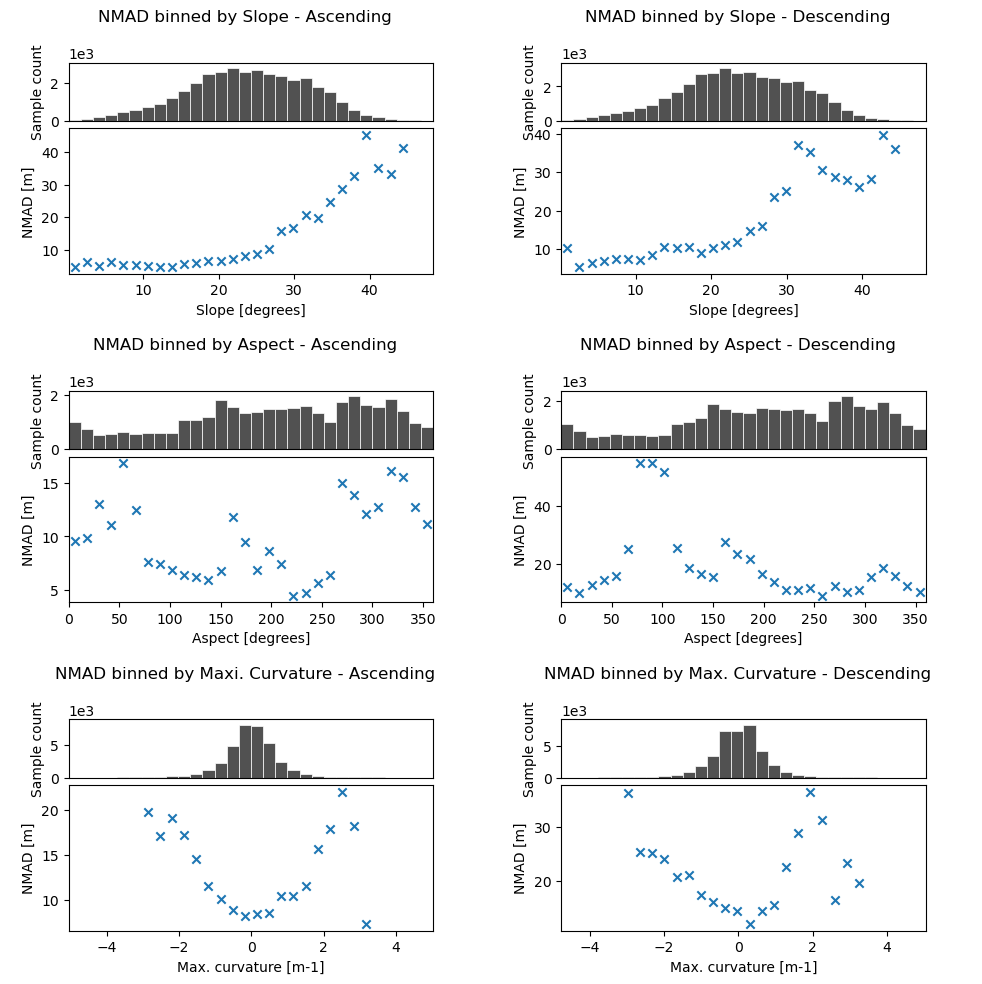

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(10, 10)) 

# plots 
# slope
xdem.spatialstats.plot_1d_binning(
    df_asc, var_name="slope", statistic_name="nmad", label_var="Slope [degrees]", label_statistic="NMAD [m]", ax=axs[0, 0]
)
xdem.spatialstats.plot_1d_binning(
    df_desc, var_name="slope", statistic_name="nmad", label_var="Slope [degrees]", label_statistic="NMAD [m]", ax=axs[0, 1]
)
# aspect
xdem.spatialstats.plot_1d_binning(
    df_asc, var_name="aspect", statistic_name="nmad", label_var="Aspect [degrees]", label_statistic="NMAD [m]", ax=axs[1, 0]
)
xdem.spatialstats.plot_1d_binning(
    df_desc, var_name="aspect", statistic_name="nmad", label_var="Aspect [degrees]", label_statistic="NMAD [m]", ax=axs[1, 1]
)
# maximum curvature
xdem.spatialstats.plot_1d_binning(
    df_asc, var_name="maxc", statistic_name="nmad", label_var="Max. curvature [m-1]", label_statistic="NMAD [m]", ax=axs[2, 0]
)
xdem.spatialstats.plot_1d_binning(
    df_desc, var_name="maxc", statistic_name="nmad", label_var="Max. curvature [m-1]", label_statistic="NMAD [m]", ax=axs[2, 1]
)

# set titles 
axs[0, 0].set_title('NMAD binned by Slope - Ascending') 
axs[0, 1].set_title('NMAD binned by Slope - Descending')
axs[1, 0].set_title('NMAD binned by Aspect - Ascending') 
axs[1, 1].set_title('NMAD binned by Aspect - Descending')
axs[2, 0].set_title('NMAD binned by Maxi. Curvature - Ascending') 
axs[2, 1].set_title('NMAD binned by Max. Curvature - Descending')

plt.tight_layout() 
#fig.savefig("terrain_aspects.png", dpi=300)
plt.show() 


In [23]:
# Print heteroscedasticity ascending
slope, maxc = xdem.terrain.get_terrain_attribute(
    dem=dem_ref, attribute=["slope", "maximum_curvature"]
)
errors, df_binning, error_function = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dvalues=ddem_asc_coreg, list_var=[slope, maxc], list_var_names=["slope", "maximum_curvature"]
)
for slope, maxc in [(0, 0), (11, 0), (40, 0), (0, 5), (11, 5), (40, 5)]:
    print(
        "Error for a slope of {:.0f} degrees and"
        " {:.2f} m-1 max. curvature: {:.1f} m".format(slope, maxc / 100, error_function((slope, maxc)))
    )

Error for a slope of 0 degrees and 0.00 m-1 max. curvature: 4.4 m
Error for a slope of 11 degrees and 0.00 m-1 max. curvature: 4.5 m
Error for a slope of 40 degrees and 0.00 m-1 max. curvature: 11.6 m
Error for a slope of 0 degrees and 0.05 m-1 max. curvature: 4.4 m
Error for a slope of 11 degrees and 0.05 m-1 max. curvature: 5.2 m
Error for a slope of 40 degrees and 0.05 m-1 max. curvature: 11.6 m


In [24]:
slope, maxc = xdem.terrain.get_terrain_attribute(
    dem=dem_ref, attribute=["slope", "maximum_curvature"]
)
errors, df_binning, error_function = xdem.spatialstats.infer_heteroscedasticity_from_stable(
    dvalues=ddem_desc_coreg, list_var=[slope, maxc], list_var_names=["slope", "maximum_curvature"]
)
for slope, maxc in [(0, 0), (11, 0), (40, 0), (0, 5), (11, 5), (40, 5)]:
    print(
        "Error for a slope of {:.0f} degrees and"
        " {:.2f} m-1 max. curvature: {:.1f} m".format(slope, maxc / 100, error_function((slope, maxc)))
    )

Error for a slope of 0 degrees and 0.00 m-1 max. curvature: 5.2 m
Error for a slope of 11 degrees and 0.00 m-1 max. curvature: 7.5 m
Error for a slope of 40 degrees and 0.00 m-1 max. curvature: 20.9 m
Error for a slope of 0 degrees and 0.05 m-1 max. curvature: 5.2 m
Error for a slope of 11 degrees and 0.05 m-1 max. curvature: 13.1 m
Error for a slope of 40 degrees and 0.05 m-1 max. curvature: 20.0 m
